In [1]:
%pylab inline
from jax.config import config
config.update("jax_enable_x64", True)

import jax
import jax_cosmo as jc
import jax.numpy as jnp

Populating the interactive namespace from numpy and matplotlib


# Step 0: Defining the fiducial cosmology

In [2]:
# Create a cosmology with default parameters
cosmo = jc.Planck15()

In [3]:
cosmo

Cosmological parameters: 
    h:        0.6774 
    Omega_b:  0.0486 
    Omega_c:  0.2589 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9667 
    sigma8:   0.8159

# Step I: Defining the probes


In [4]:
# Making one small redshift bin at z=0.91
from scipy.stats import norm
z = jnp.linspace(0,2,1024)
nzs_lensing = [jc.redshift.kde_nz(z, norm.pdf(z, loc=0.91, scale=0.01), bw=0.01,
                                  gals_per_arcmin2=10., zmax=1.)]

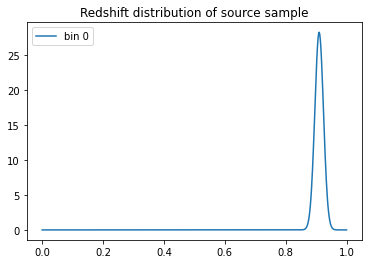

In [5]:
# Plotting the redshift distribution of lensing sample
zs = np.linspace(0, 1, 512)
for i in range(1):
  plot(zs, nzs_lensing[i](zs), label='bin %d'%i)
legend()
title('Redshift distribution of source sample');

In [6]:
probes = [ jc.probes.WeakLensing(nzs_lensing, sigma_e=0.26)]

In [7]:
ell = np.logspace(2,jnp.log10(3_000)) # Defines a range of \ell

# And compute the data vector and covariance matrix
mu, cov = jc.angular_cl.gaussian_cl_covariance_and_mean(cosmo, ell, probes, sparse=True, f_sky=15_000/40_000);

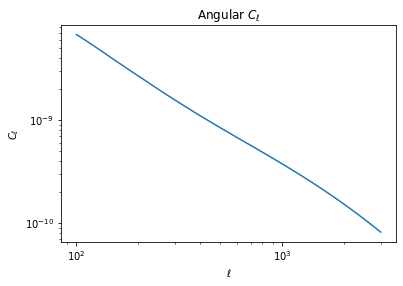

In [8]:
# This is for instance the first bin auto-spectrum 
loglog(ell, mu)
ylabel(r'$C_\ell$')
xlabel(r'$\ell$');
title(r'Angular $C_\ell$');

In [9]:
data = mu # We create some fake data from the fiducial cosmology
# Let's define a parameter vector for Omega_cdm, sigma8, which we initialize 
# at the fiducial cosmology used to produce the data vector.
params = np.array([cosmo.Omega_c, cosmo.sigma8, cosmo.Omega_b,  cosmo.h, cosmo.n_s, cosmo.w0, 0.0]) 
params_names = ["$\Omega_c$",  "$\sigma_8$", "$\Omega_b$", "$h$", "$n_s$", "$w0$", "$A_{IA}$"]

# We define a parameter dependent function that computes the mean
@jax.jit
def mean_fn(p):
  cosmo = jc.Planck15(Omega_c=p[0], sigma8=p[1], Omega_b=p[2],  h=p[3], n_s=p[4], w0=p[5])

  probes = [ jc.probes.WeakLensing(nzs_lensing, sigma_e=0.26,
                                   ia_bias=[jc.bias.constant_linear_bias(p[6])])]

  # Compute signal vector
  m = jc.angular_cl.angular_cl(cosmo, ell, probes)
  return m.flatten() # We want it in 1d to operate against the covariance matrix

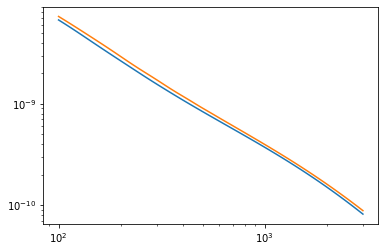

In [10]:
loglog(ell, mean_fn(params))
loglog(ell, mean_fn(params + [0.0,0,0,0,0,0,1.0])) # Adding a little bit of IA to see the impact

In [11]:
# We compute it's jacobian with JAX, and we JIT it for efficiency
jac_mean = jax.jit(jax.jacfwd(mean_fn))

In [12]:
# We can now evaluate the jacobian at the fiducial cosmology
dmu = jac_mean(params)

In [13]:
# Now we can compose the Fisher matrix:
F = jc.sparse.dot(dmu.T, jc.sparse.inv(cov), dmu)
print("Fisher matrix conditionning before priors", cond(F))
# Adding priors
F  = F + jnp.diag(1./jnp.array([0.2, 0.14, 0.006, 0.063, 0.08, 0.8, 3.]))**2
print("Fisher matrix conditionning before priors", cond(F))
P = jnp.linalg.pinv(F)

Fisher matrix conditionning before priors 80376455182.74644
Fisher matrix conditionning before priors 57881379.795189686


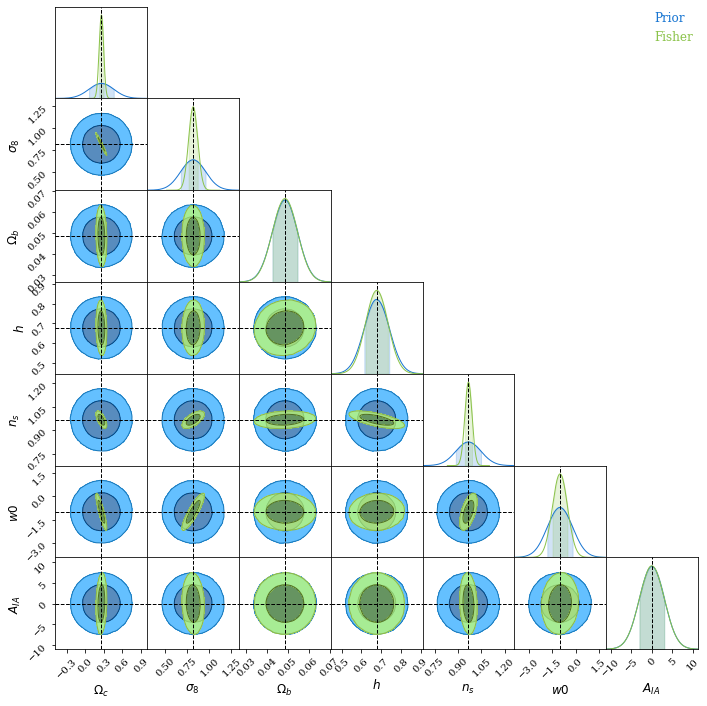

In [14]:
from chainconsumer import ChainConsumer
c = ChainConsumer()
c.add_covariance(params, jnp.diag(jnp.array([0.2, 0.14, 0.006, 0.063, 0.08, 0.8, 3.]))**2, 
                 parameters=params_names, name="Prior")
c.add_covariance(params, P, 
                 parameters=params_names, name="Fisher")
c.configure(usetex=False)
fig = c.plotter.plot(truth=params)

In [15]:
P20 = jnp.array([[ 1.79682156e-03, -1.71574191e-03,  3.92268468e-06,
              -9.95369940e-04, -9.79223915e-04,  1.05382963e-02,
               2.08646934e-02],
             [-1.71574191e-03,  1.69666903e-03, -3.34721637e-05,
               8.26148026e-04,  9.42540031e-04, -9.83452901e-03,
              -2.25733893e-02],
             [ 3.92268468e-06, -3.34721637e-05,  3.54016571e-05,
               1.43633836e-05,  1.83680314e-06,  2.33846402e-04,
               9.25791016e-05],
             [-9.95369940e-04,  8.26148026e-04,  1.43633836e-05,
               3.58310130e-03, -3.30489342e-04, -5.92584111e-03,
              -2.44893277e-03],
             [-9.79223915e-04,  9.42540031e-04,  1.83680314e-06,
              -3.30489342e-04,  8.17870814e-04, -5.94299275e-03,
              -9.95675317e-03],
             [ 1.05382963e-02, -9.83452901e-03,  2.33846402e-04,
              -5.92584111e-03, -5.94299275e-03,  6.97898527e-02,
              -6.77132799e-03],
             [ 2.08646934e-02, -2.25733893e-02,  9.25791016e-05,
              -2.44893277e-03, -9.95675317e-03, -6.77132799e-03,
               8.84621239e+00]])

In [16]:
P5 = jnp.array([[ 2.65181374e-03, -2.69509160e-03,  7.78453798e-06,
              -1.08187486e-03, -1.42656814e-03,  1.39364425e-02,
               1.45980539e-02],
             [-2.69509160e-03,  2.88278347e-03, -3.78618466e-05,
               9.20280815e-04,  1.37255700e-03, -1.30007752e-02,
              -1.56596572e-02],
             [ 7.78453798e-06, -3.78618466e-05,  3.56229624e-05,
               9.15261724e-06,  1.47408953e-06,  2.52215610e-04,
              -1.29274578e-05],
             [-1.08187486e-03,  9.20280815e-04,  9.15261724e-06,
               3.70888827e-03, -3.18348634e-04, -6.38853669e-03,
               1.89730671e-04],
             [-1.42656814e-03,  1.37255700e-03,  1.47408953e-06,
              -3.18348634e-04,  1.21253549e-03, -8.61198839e-03,
              -6.95371861e-03],
             [ 1.39364425e-02, -1.30007752e-02,  2.52215610e-04,
              -6.38853669e-03, -8.61198839e-03,  9.17231593e-02,
              -3.58004490e-02],
             [ 1.45980539e-02, -1.56596572e-02, -1.29274578e-05,
               1.89730671e-04, -6.95371861e-03, -3.58004490e-02,
               8.93623302e+00]])

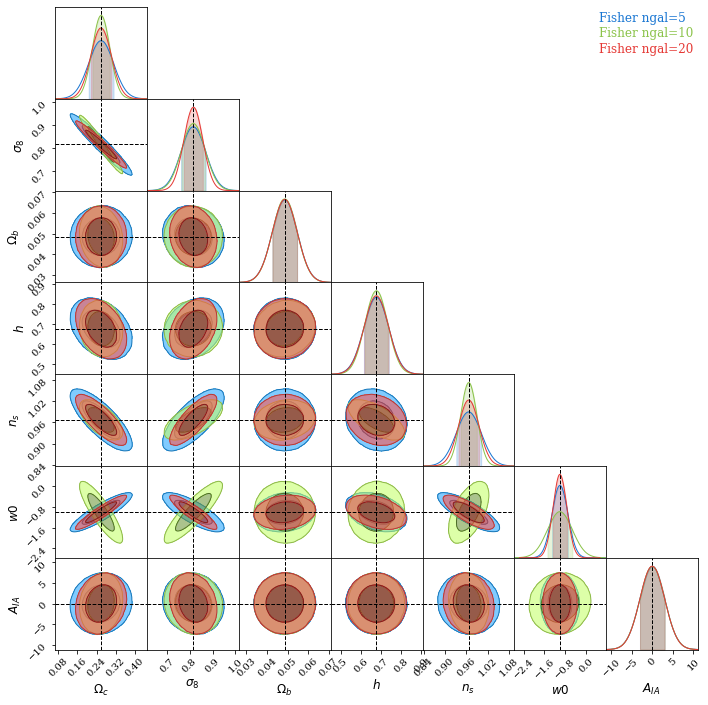

In [17]:
c = ChainConsumer()
c.add_covariance(params, P5, 
                  parameters=params_names, name="Fisher ngal=5")
c.add_covariance(params, P, 
                 parameters=params_names, name="Fisher ngal=10")
c.add_covariance(params, P20, 
                  parameters=params_names, name="Fisher ngal=20")
c.configure(usetex=False)
fig = c.plotter.plot(truth=params)

In [18]:
jc.background.f_de??

Signature: jc.background.f_de(cosmo, a)
Docstring:
Evolution parameter for the Dark Energy density.

Parameters
----------
a : array_like
    Scale factor

Returns
-------
f : ndarray, or float if input scalar
    The evolution parameter of the Dark Energy density as a function
    of scale factor

Notes
-----

For a given parametrisation of the Dark Energy equation of state,
the scaling of the Dark Energy density with time can be written as:

.. math::

    \rho_{de}(a) \propto a^{f(a)}

(see :cite:`2005:Percival`) where :math:`f(a)` is computed as
:math:`f(a) = \frac{-3}{\ln(a)} \int_0^{\ln(a)} [1 + w(a^\prime)]
d \ln(a^\prime)`. In the case of Linder's parametrisation for the
dark energy in Eq. :eq:`linderParam` :math:`f(a)` becomes:

.. math::

    f(a) = -3(1 + w_0) + 3 w \left[ \frac{a - 1}{ \ln(a) } - 1 \right]
    
Source:   
def f_de(cosmo, a):
    r"""Evolution parameter for the Dark Energy density.

    Parameters
    ----------
    a : array_like
        Scale factor

    R